In [60]:
import torch
import torchvision

class TrainData:
    def __init__(self):
        self._download_train_data()
        
    def _download_train_data(self):
        orig_train = torchvision.datasets.CIFAR10('data', train=True, transform=torchvision.transforms.ToTensor(), download=True)

        classes = tuple(orig_train.classes)

        keep_labels = (classes.index('cat'), classes.index('dog'))  #tuple(range(len(classes)))
        aux_labels = tuple(classes.index(a) for a in ['airplane', 'automobile', 'bird', 'ship', 'truck'])
        n = 5000 * len(keep_labels)
        auxn = 25000
        channels = 3
        w = 32
        h = 32
        X = torch.zeros((n, channels, w, h))
        y = torch.zeros((n,), dtype=torch.long)
        auxX = torch.zeros((auxn, channels, w, h))

        j = 0
        auxj = 0
        for x,label in orig_train:
            if label in keep_labels:
                X[j,:,:,:] = x
                y[j] = keep_labels.index(label)
                j += 1
            if label in aux_labels:
                auxX[auxj,:,:,:] = x
                auxj += 1
        if j != n:
            raise Exception(f"Wrong number of valid examples {j} {n}")
        if auxj != auxn:
            raise Exception(f"Wrong number of aux examples {auxj} {auxn}")
        self._X = X
        self._y = y
        self._n = n
        self._auxX = auxX
        self._auxn = auxn
        self._n_classes = len(keep_labels)
        
    def in_distribution_dataset(self):
        return [(self._X[i], (self._y[i], 0)) for i in range(self._n)]
        
    def mixed_dataset(self):
        ind = [(self._X[i], (self._y[i], 0)) for i in range(self._n)]
        ood = [(self._auxX[i], (torch.zeros(()), 1)) for i in range(self._auxn)]
        #ood = []
        return ind + ood
    
    def n_classes(self):
        return self._n_classes
        
train_data = TrainData()
print("Have training data")

Files already downloaded and verified
Have training data


In [61]:

class TestData:
    def __init__(self):
        self._download_test_data()
        
    def _download_test_data(self):
        orig_train = torchvision.datasets.CIFAR10('data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

        classes = tuple(orig_train.classes)

        keep_labels = (classes.index('cat'), classes.index('dog'))   # tuple(range(len(classes)))
        ood_labels = tuple(classes.index(a) for a in ['deer','frog','horse'])
        n = 1000 * len(keep_labels)
        oodn = 3000
        channels = 3
        w = 32
        h = 32
        X = torch.zeros((n, channels, w, h))
        y = torch.zeros((n,), dtype=torch.long)
        oodX = torch.zeros((oodn, channels, w, h))

        j = 0
        oodj = 0
        for x,label in orig_train:
            if label in keep_labels:
                X[j,:,:,:] = x
                y[j] = keep_labels.index(label)
                j += 1
            if label in ood_labels:
                oodX[oodj,:,:,:] = x
                oodj += 1
        if j != n:
            raise Exception(f"Wrong number of valid examples {j} {n}")
        if oodj != oodn:
            raise Exception(f"Wrong number of ood examples {oodj} {oodn}")
        self._X = X
        self._y = y
        self._n = n
        self._oodX = oodX
        self._oodn = oodn
        
    def in_distribution_dataset(self):
        return [(self._X[i], self._y[i]) for i in range(self._n)]
        
    def mixed_dataset(self):
        ind = [(self._X[i], 0) for i in range(self._n)]
        ood = [(self._oodX[i], 1) for i in range(self._oodn)]
        return ind + ood
    
    def mixed_n(self):
        return self._n + self._oodn
        
test_data = TestData()
print("Have test data")

Files already downloaded and verified
Have test data


In [62]:
class SimpleCnnModel(torch.nn.Module):
    def __init__(self, method):
        super().__init__()
        self.base_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(64, 32, 4),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
        )
        self.probs_layers = torch.nn.Sequential(
            torch.nn.Linear(288, 1),
            torch.nn.Sigmoid(),
        )
        self.method = method
        if method == 'exposure':
            self.ood_layers = torch.nn.Sequential(
                torch.nn.Linear(288, 1),
                torch.nn.Sigmoid(),
            )


    def forward(self, x):
        x2 = self.base_layers(x)
        probs = self.probs_layers(x2).flatten(start_dim=0)
        if self.method == 'confidence':
            ood_probs = 1 - (probs * 2 - 1) ** 2
        elif self.method == 'exposure':
            ood_probs = self.ood_layers(x2).flatten(start_dim=0)
        else:
            raise Exception(f"Unrecognized method: {self.method}")
        return probs, ood_probs


In [77]:
from sklearn.metrics import roc_curve, auc

class Experiment:
    def __init__(self, method='confidence', num_epochs=100):
        global train_data
        global test_data
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        if train_data.n_classes() != 2:
            raise Exception("Binary classifiers only")
        self.model = SimpleCnnModel(method).to(self.device)
        
        self.train_on_mixed_data = (method == 'exposure')
        self.method = method
        
        if self.train_on_mixed_data:
            print("Training on mixed in-distribution and out-of-distribution examples")
            self.dataloader = torch.utils.data.DataLoader(
                train_data.mixed_dataset(),
                batch_size=64,
                shuffle=True
            )
        else:
            print("Training on in-distribution examples only")
            self.dataloader = torch.utils.data.DataLoader(
                train_data.in_distribution_dataset(),
                batch_size=64,
                shuffle=True
            )
        self.test_dataloader = torch.utils.data.DataLoader(
            test_data.in_distribution_dataset(),
            batch_size=64,
            shuffle=False
        )
        self.test_mixed_dataloader = torch.utils.data.DataLoader(
            test_data.mixed_dataset(),
            batch_size=64,
            shuffle=False
        )
        self.test_mixed_n = test_data.mixed_n()
        self.loss_fn = torch.nn.BCELoss(reduction='none')
        if self.method == 'exposure':
            self.ood_loss_fn = torch.nn.BCELoss(reduction='sum')
        else:
            self.ood_loss_fn = lambda a,b: torch.zeros(()).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), weight_decay=0.4, lr=0.001)
        self.num_epochs = num_epochs

    def _train(self):
        print(self.device)
        train_accs = []
        test_accs = []
        aucs = []
        epochs = []
        for epoch in range(self.num_epochs):
            running_loss = torch.zeros(())
            train_accuracy = torch.zeros(())
            running_count = torch.zeros(())
            for inputs, (labels, ood_labels) in self.dataloader:
                self.optimizer.zero_grad()
                outputs, ood_outputs = self.model(inputs.to(self.device))
                predictions = outputs.detach() >= 0.5
                labels_device = labels.to(self.device)
                if self.train_on_mixed_data:
                    ood_labels_device = ood_labels.to(self.device)
                    loss = (
                        (self.loss_fn(outputs, labels_device.to(torch.float)) * (1 - ood_labels_device)).sum()
                            + self.ood_loss_fn(ood_outputs, ood_labels_device.to(torch.float))
                    )
                else:
                    loss = self.loss_fn(outputs, labels_device.to(torch.float)).sum()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.detach().to('cpu')
                train_accuracy += ((predictions == labels_device) * (1 - ood_labels_device)).sum().to('cpu')
                running_count += (1 - ood_labels_device).sum().to('cpu')
                    
            test_accuracy = torch.zeros(())
            test_count = 0
            with torch.no_grad():
                for inputs, labels in self.test_dataloader:
                    outputs, ood_outputs = self.model(inputs.to(self.device))
                    predictions = outputs >= 0.5
                    test_accuracy += (predictions.to('cpu') == labels).sum()
                    test_count += outputs.shape[0]

            train_acc = train_accuracy.item() / running_count.item()
            test_acc = test_accuracy.item() / test_count
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            epochs.append(epoch)

                
            # Calculate ROC curve
            ood_y_true = torch.zeros((self.test_mixed_n,))
            ood_y_score = torch.zeros((self.test_mixed_n,))
            with torch.no_grad():
                pos = 0
                for inputs, ood_labels in self.test_mixed_dataloader:
                    outputs, ood_outputs = self.model(inputs.to(self.device))
                    batch_n, = ood_labels.shape
                    ood_y_true[pos:pos+batch_n] = ood_labels
                    ood_y_score[pos:pos+batch_n] = ood_outputs
                    pos += batch_n
            ood_roc = roc_curve(y_true=ood_y_true, y_score=ood_y_score)
            ood_auc = auc(ood_roc[0], ood_roc[1])
            aucs.append(ood_auc)

            if epoch % 5 == 4:
                print('Epoch', f'{epoch:2}',
                      'Train_acc', f'{train_acc:8}',
                      '  Test_acc', f'{test_acc:8}',
                      '  Ood_AUC', ood_auc
                     )
            
                
        return epochs, train_accs, test_accs, aucs, ood_roc

Training on mixed in-distribution and out-of-distribution examples
cuda:0
Epoch  4 Train_acc   0.6271   Test_acc   0.6035   Ood_AUC 0.7068253333333333
Epoch  9 Train_acc    0.648   Test_acc    0.639   Ood_AUC 0.7244871666666667
Epoch 14 Train_acc   0.6604   Test_acc    0.676   Ood_AUC 0.7313124166666667
Epoch 19 Train_acc   0.6699   Test_acc    0.676   Ood_AUC 0.730413
Epoch 24 Train_acc    0.671   Test_acc    0.665   Ood_AUC 0.7433853333333332


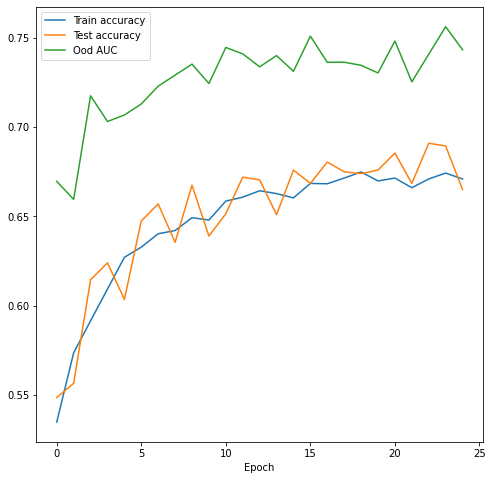

In [80]:
import matplotlib.pyplot as plt
e, tr, te, aucs, roc = Experiment('exposure',25)._train()
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot(e, tr, label='Train accuracy')
plt.plot(e, te, label='Test accuracy')
plt.plot(e, aucs, label='Ood AUC')
plt.legend()
plt.xlabel('Epoch')
None

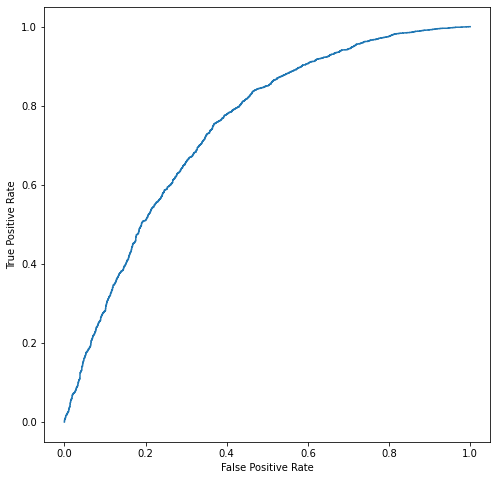

In [81]:
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc
plt.rcParams['figure.figsize'] = [8, 8]
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
None